In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
inv_prts = pd.read_csv("inventory_parts.csv")
inv = pd.read_csv("inventories.csv")
clrs = pd.read_csv("colors.csv")
sets = pd.read_csv("sets.csv")

In [3]:
inv_f = pd.merge(inv_prts, inv, left_on="inventory_id", right_on="id", how="inner")
inv_ff = pd.merge(inv_f, clrs, left_on="color_id", right_on="id", how="inner")
inv_ff = inv_ff.drop(columns={"id_x", "id_y"})
inv_ff.columns=["inventory_id", "part_num", "color_id", "quantity", "is_spare", "version", "set_num", "name","rgb", "is_trans"]

inventory = pd.merge(inv_ff, sets, on="set_num", how="inner")
inventory = inventory.rename(columns={"name_x":"Color_name", "name_y":"Set name"})
inventory = inventory.drop(columns={"part_num", "set_num", "Color_name", "rgb", "Set name"})

In [4]:
inventory.head()

,inventory_id,color_id,quantity,is_spare,version,is_trans,year,theme_id,num_parts
0,1,72,1,f,1,f,2004,460,4
1,1,7,1,f,1,f,2004,460,4
2,1,25,1,f,1,f,2004,460,4
3,1,0,1,f,1,f,2004,460,4
4,22,72,1,f,1,f,2016,184,56


In [5]:
inventory_1 = inventory[["inventory_id", "color_id", "quantity", "version", "year", "theme_id", "num_parts", "is_spare", "is_trans"]]
inventory_2 = inventory[["inventory_id", "color_id", "quantity", "version", "year", "theme_id", "num_parts", "is_trans", "is_spare"]]

inventory_1 = inventory_1.sample(frac=0.5, random_state=1)
inventory_2 = inventory_2.sample(frac=0.5, random_state=1)

inventory_1 = np.array(inventory_1)
inventory_2 = np.array(inventory_2)

inventory_1[:,7] = (inventory_1[:,7] == "f").astype(int)
inventory_2[:,7] = (inventory_2[:,7] == "f").astype(int)
inventory_1[:,8] = (inventory_1[:,8] == "f").astype(int)
inventory_2[:,8] = (inventory_2[:,8] == "f").astype(int)

In [6]:
x1 = inventory_1[:,0:8]
y1 = inventory_1[:,8]
y1 = y1.reshape(x1.shape[0],1)
y1 = y1.astype('int')

x2 = inventory_2[:,0:8]
y2 = inventory_2[:,8]
y2 = y2.reshape(x2.shape[0],1)
y2 = y2.astype('int')

In [7]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.15, random_state=7)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.15, random_state=7)

In [8]:
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape)
print(x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(246607, 8) (43519, 8) (246607, 1) (43519, 1)
(246607, 8) (43519, 8) (246607, 1) (43519, 1)


In [9]:
x1_train = x1_train.T
x1_test = x1_test.T
y1_train = y1_train.T
y1_test = y1_test.T

x2_train = x2_train.T
x2_test = x2_test.T
y2_train = y2_train.T
y2_test = y2_test.T

In [10]:
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape)
print(x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(8, 246607) (8, 43519) (1, 246607) (1, 43519)
(8, 246607) (8, 43519) (1, 246607) (1, 43519)


Cost after iteration 0: 9.210340
Cost after iteration 10: 9.210340
Cost after iteration 20: 9.210340
Cost after iteration 30: 9.210340
Cost after iteration 40: 9.210340
Cost after iteration 50: 9.210340
Cost after iteration 60: 9.210340
Cost after iteration 70: 9.210340
Cost after iteration 80: 0.045615
Cost after iteration 90: 9.210340
Cost after iteration 100: 9.210340
Cost after iteration 110: 9.210340
Cost after iteration 120: 9.210340
Cost after iteration 130: 9.210340
Cost after iteration 140: 9.210340


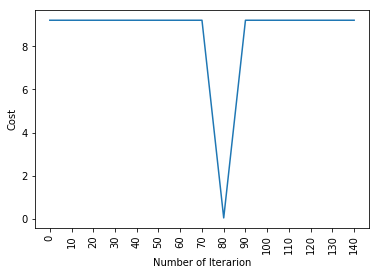

train accuracy: 99.93689554635513 %
test accuracy: 99.93680920977044 %


In [11]:
def init_w_b(dimension1):
    w1 = np.full((dimension1,1),1)
    b1 = 0.0
    return w1, b1

def sigmoid(z1):
    y1_head = 1/(1+np.exp((-z1.astype(int))))
    return y1_head

def fw_bw_propagation(w1,b1,x1_train,y1_train):
    z1 = np.dot(w1.T,x1_train) + b1
    y1_head = sigmoid(z1.astype(int)) # probabilistic 0-1
    loss1 = -y1_train*np.log(1-y1_head+1e-4)-(1-y1_train)*np.log(1-y1_head+1e-4)
    cost1 = (np.sum(loss1))/x1_train.shape[1]
    
    # backward propagation
    derivative_weight1 = (np.dot(x1_train,((y1_head-y1_train+1e-4).T)))/x1_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias1 = np.sum(y1_head-y1_train+1e-4)/x1_train.shape[1]           # x_train.shape[1]  is for scaling
    gradients1 = {"derivative_weight1": derivative_weight1,"derivative_bias1": derivative_bias1}
    return cost1,gradients1

def update(w1, b1, x1_train, y1_train, learning_rate, number_of_iteration):
    cost1_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost1,gradients1 = fw_bw_propagation(w1,b1,x1_train,y1_train)
        cost1_list.append(cost1)
        # lets update
        w1 = w1 - learning_rate * gradients1["derivative_weight1"]
        b1 = b1 - learning_rate * gradients1["derivative_bias1"]
        if i % 10 == 0:
            cost_list2.append(cost1)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost1))
    # we update(learn) parameters weights and bias
    parameters1 = {"weight": w1,"bias": b1}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters1, gradients1, cost1_list
#parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate = 0.009,number_of_iterarion = 200)

def predict(w1,b1,x1_test):
    # x_test is a input for forward propagation
    z1 = sigmoid(np.dot(w1.T,x1_test)+b1)
    Y1_prediction = np.zeros((1,x1_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z1.shape[1]):
        if z1[0,i]<= 0.5:
            Y1_prediction[0,i] = 0
        else:
            Y1_prediction[0,i] = 1

    return Y1_prediction
# predict(parameters["weight"],parameters["bias"],x_test)

def logistic_regression(x1_train, y1_train, x1_test, y1_test, learning_rate , num_iterations):
    # initialize
    dimension =  x1_train.shape[0]
    w1,b1 = init_w_b(dimension)
    # do not change learning rate
    parameters1, gradients1, cost1_list = update(w1, b1, x1_train, y1_train, learning_rate, num_iterations)
    
    y1_prediction_test = predict(parameters1["weight"],parameters1["bias"],x1_test)
    y1_prediction_test = y1_prediction_test.astype('int')
    y1_prediction_train = predict(parameters1["weight"],parameters1["bias"],x1_train)
    y1_prediction_train = y1_prediction_train.astype('int')

    print("train accuracy: {} %".format(100 - np.mean(np.abs(y1_prediction_train - y1_train))))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y1_prediction_test - y1_test))))
    
logistic_regression(x1_train, y1_train, x1_test, y1_test,learning_rate = 1, num_iterations = 150)

Cost after iteration 0: 9.210340
Cost after iteration 10: 9.210340
Cost after iteration 20: 5.028859
Cost after iteration 30: 9.210116
Cost after iteration 40: 9.199883
Cost after iteration 50: 9.209369
Cost after iteration 60: 9.197306
Cost after iteration 70: 9.208585
Cost after iteration 80: 9.193683
Cost after iteration 90: 9.207875
Cost after iteration 100: 9.192114
Cost after iteration 110: 9.207539
Cost after iteration 120: 9.191031
Cost after iteration 130: 9.208174
Cost after iteration 140: 9.200182


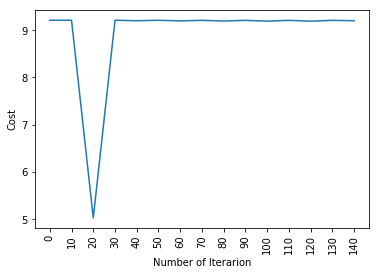

train accuracy: 99.94942560430158 %
test accuracy: 99.94894184149452 %


In [12]:
def init_w_b(dimension2):
    w2 = np.full((dimension2,1),1)
    b2 = 0.0
    return w2, b2

def sigmoid(z2):
    y2_head = 1/(1+np.exp((-z2.astype(int))))
    return y2_head

def fw_bw_propagation(w2,b2,x2_train,y2_train):
    z2 = np.dot(w2.T,x2_train) + b2
    y2_head = sigmoid(z2.astype(int)) # probabilistic 0-1
    loss2 = -y2_train*np.log(1-y2_head+1e-4)-(1-y2_train)*np.log(1-y2_head+1e-4)
    cost2 = (np.sum(loss2))/x2_train.shape[1]
    
    # backward propagation
    derivative_weight2 = (np.dot(x2_train,((y2_head-y2_train+1e-4).T)))/x2_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias2 = np.sum(y2_head-y2_train+1e-4)/x2_train.shape[1]           # x_train.shape[1]  is for scaling
    gradients2 = {"derivative_weight2": derivative_weight2,"derivative_bias2": derivative_bias2}
    return cost2,gradients2

def update(w2, b2, x2_train, y2_train, learning_rate, number_of_iteration):
    cost2_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost2,gradients2 = fw_bw_propagation(w2,b2,x2_train,y2_train)
        cost2_list.append(cost2)
        # lets update
        w2 = w2 - learning_rate * gradients2["derivative_weight2"]
        b2 = b2 - learning_rate * gradients2["derivative_bias2"]
        if i % 10 == 0:
            cost_list2.append(cost2)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost2))
    # we update(learn) parameters weights and bias
    parameters2 = {"weight": w2,"bias": b2}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters2, gradients2, cost2_list
#parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate = 0.009,number_of_iterarion = 200)

def predict(w2,b2,x2_test):
    # x_test is a input for forward propagation
    z2 = sigmoid(np.dot(w2.T,x2_test)+b2)
    Y2_prediction = np.zeros((1,x2_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z2.shape[1]):
        if z2[0,i]<= 0.5:
            Y2_prediction[0,i] = 0
        else:
            Y2_prediction[0,i] = 1

    return Y2_prediction
# predict(parameters["weight"],parameters["bias"],x_test)

def logistic_regression(x2_train, y2_train, x2_test, y2_test, learning_rate , num_iterations):
    # initialize
    dimension =  x2_train.shape[0]
    w2,b2 = init_w_b(dimension)
    # do not change learning rate
    parameters2, gradients2, cost2_list = update(w2, b2, x2_train, y2_train, learning_rate, num_iterations)
    
    y2_prediction_test = predict(parameters2["weight"],parameters2["bias"],x2_test)
    y2_prediction_test = y2_prediction_test.astype('int')
    y2_prediction_train = predict(parameters2["weight"],parameters2["bias"],x2_train)
    y2_prediction_train = y2_prediction_train.astype('int')

    print("train accuracy: {} %".format(100 - np.mean(np.abs(y2_prediction_train - y2_train))))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y2_prediction_test - y2_test))))
    
logistic_regression(x2_train, y2_train, x2_test, y2_test,learning_rate = 1, num_iterations = 150)

In [13]:
logreg1 = LogisticRegression(random_state = 42,max_iter= 150, solver='lbfgs', multi_class='ovr')
logreg1 = logreg1.fit(x1_train.T, y1_train.T)
print("Train accuracy for is_trans :", logreg1.score(x1_train.T, y1_train.T))
y_pred1 = logreg1.predict(x1_test.T)
print("Test accuracy for is_trans:", (100 - np.mean(np.abs(y_pred1 - y1_test.T)))/100)
print("\n")

logreg2 = LogisticRegression(random_state = 42,max_iter= 150, solver='lbfgs', multi_class='ovr')
logreg2 = logreg2.fit(x2_train.T, y2_train.T)
print("Train accuracy for is_spare:", logreg2.score(x2_train.T, y2_train.T))
y_pred2 = logreg2.predict(x2_test.T)
print("Test accuracy for is_spare:", (100 - np.mean(np.abs(y_pred2 - y2_test.T)))/100)

C:\Users\Lokesh Vairamuthu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy for is_trans : 0.9368955463551318
Test accuracy for is_trans: 0.9993680920977045


Train accuracy for is_spare: 0.9496770164674969
Test accuracy for is_spare: 0.9994802028919362


In [14]:
from sklearn.neural_network import MLPClassifier

x1_train_mlp = x1_train.T
x1_test_mlp = x1_test.T
y1_train_mlp = y1_train.reshape(y1_train.shape[1])
y1_test_mlp = y1_test.reshape(y1_test.shape[1])
x2_train_mlp = x2_train.T
x2_test_mlp = x2_test.T
y2_train_mlp = y2_train.reshape(y2_train.shape[1])
y2_test_mlp = y2_test.reshape(y2_test.shape[1])


clf_mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
clf_mlp1 = clf_mlp1.fit(x1_train_mlp, y1_train_mlp)
print("Train accuracy for is_trans:", clf_mlp1.score(x1_train_mlp, y1_train_mlp))
y_pred_mlp1 = clf_mlp1.predict(x1_test_mlp)
print("Test accuracy for is_trans:", (100 - np.mean(np.abs(y_pred_mlp1 - y1_test_mlp)))/100)
print("\n")
clf_mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
clf_mlp2 = clf_mlp2.fit(x2_train_mlp, y2_train_mlp)
print("Train accuracy for is_spare:", clf_mlp2.score(x2_train_mlp, y2_train_mlp))
y_pred_mlp2 = clf_mlp2.predict(x2_test_mlp)
print("Test accuracy for is_spare:", (100 - np.mean(np.abs(y_pred_mlp2 - y2_test_mlp)))/100)

Train accuracy for is_trans: 0.06310445364486815
Test accuracy for is_trans: 0.9906319079022956


Train accuracy for is_spare: 0.05055412052374831
Test accuracy for is_spare: 0.9905098922309796


In [15]:
from sklearn.neighbors import KNeighborsClassifier

x1_train_knc = x1_train.T
x1_test_knc = x1_test.T
y1_train_knc = y1_train.reshape(y1_train.shape[1])
y1_test_knc = y1_test.reshape(y1_test.shape[1])
x2_train_knc = x2_train.T
x2_test_knc = x2_test.T
y2_train_knc = y2_train.reshape(y2_train.shape[1])
y2_test_knc = y2_test.reshape(y2_test.shape[1])

clf_knc1 = KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto")
clf_knc1 = clf_knc1.fit(x1_train_knc, y1_train_knc)
print("Train accuracy for is_trans:", clf_knc1.score(x1_train_knc, y1_train_knc))
y_pred_knc1 = clf_knc1.predict(x1_test_knc)
print("Test accuracy for is_trans:", (100 - np.mean(np.abs(y_pred_knc1 - y1_test_knc)))/100)
print("\n")
clf_knc2 = KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto")
clf_knc2 = clf_mlp2.fit(x2_train_knc, y2_train_knc)
print("Train accuracy for is_spare:", clf_knc2.score(x2_train_knc, y2_train_knc))
y_pred_knc2 = clf_knc2.predict(x2_test_knc)
print("Test accuracy for is_spare:", (100 - np.mean(np.abs(y_pred_knc2 - y2_test_knc)))/100)

Train accuracy for is_trans: 0.9784272141504499
Test accuracy for is_trans: 0.9996612973643696


Train accuracy for is_spare: 0.05055412052374831
Test accuracy for is_spare: 0.9905098922309796


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

x1_train_dt = x1_train.T
x1_test_dt = x1_test.T
y1_train_dt = y1_train.reshape(y1_train.shape[1])
y1_test_dt = y1_test.reshape(y1_test.shape[1])
x2_train_dt = x2_train.T
x2_test_dt = x2_test.T
y2_train_dt = y2_train.reshape(y2_train.shape[1])
y2_test_dt = y2_test.reshape(y2_test.shape[1])

clf_dt1 = DecisionTreeClassifier(random_state=0)
clf_dt1 = clf_dt1.fit(x1_train_dt, y1_train_dt)
print("Train accuracy for is_trans of Decision Tree:", clf_dt1.score(x1_train_dt, y1_train_dt))
y_pred_dt1 = clf_dt1.predict(x1_test_dt)
print("Test accuracy for is_trans of Decision Tree:", (100 - np.mean(np.abs(y_pred_dt1 - y2_test_dt)))/100)
print(cross_val_score(clf_dt1, x1_train_dt, y1_train_dt, cv=10))
print("\n")

clf_dt2 = DecisionTreeClassifier(random_state=0)
clf_dt2 = clf_dt2.fit(x2_train_dt, y2_train_dt)
print("Train accuracy for is_spare of Decision Tree:", clf_dt2.score(x2_train_dt, y2_train_dt))
y_pred_dt2 = clf_dt2.predict(x2_test_dt)
print("Test accuracy for is_spare of Decision Tree:", (100 - np.mean(np.abs(y_pred_dt2 - y2_test_dt)))/100)
print(cross_val_score(clf_dt2, x2_train_dt, y2_train_dt, cv=10))

Train accuracy for is_trans of Decision Tree: 1.0
Test accuracy for is_trans of Decision Tree: 0.9990691422137458
[0.99995945 0.9999189  0.99995945 0.9998378  1.         0.99987835
 1.         0.99995945 0.99995945 1.        ]


Train accuracy for is_spare of Decision Tree: 0.9719675435003873
Test accuracy for is_spare of Decision Tree: 0.9992520508283738
[0.92680751 0.92478002 0.92295527 0.92518552 0.92591541 0.92587486
 0.92384737 0.92408759 0.92278994 0.92664234]


In [35]:
from sklearn.ensemble import RandomForestClassifier

x1_train_rfc = x1_train.T
x1_test_rfc = x1_test.T
y1_train_rfc = y1_train.reshape(y1_train.shape[1])
y1_test_rfc = y1_test.reshape(y1_test.shape[1])
x2_train_rfc = x2_train.T
x2_test_rfc = x2_test.T
y2_train_rfc = y2_train.reshape(y2_train.shape[1])
y2_test_rfc = y2_test.reshape(y2_test.shape[1])

clf_rfc1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_rfc1 = clf_rfc1.fit(x1_train_rfc, y1_train_rfc)
print("Train accuracy for is_spare of Random Forest Classifier:", clf_rfc1.score(x1_train_rfc, y1_train_rfc))
y_pred_rfc1 = clf_rfc1.predict(x1_test_rfc)
print("Test accuracy for is_spare of Random Forest Classifier:", (100 - np.mean(np.abs(y_pred_rfc1 - y1_test_rfc)))/100)
print(cross_val_score(clf_rfc1, x1_train_rfc, y1_train_rfc, cv=10))
print(clf_rfc1.feature_importances_)
print("\n")

clf_rfc2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_rfc2 = clf_rfc2.fit(x2_train_rfc, y2_train_rfc)
print("Train accuracy for is_spare of Random Forest Classifier:", clf_rfc2.score(x2_train_rfc, y2_train_rfc))
y_pred_rfc2 = clf_rfc2.predict(x2_test_rfc)
print("Test accuracy for is_spare of Random Forest Classifier:", (100 - np.mean(np.abs(y_pred_rfc2 - y2_test_rfc)))/100)
print(cross_val_score(clf_rfc2, x2_train_rfc, y2_train_rfc, cv=10))
print(clf_rfc2.feature_importances_)

Train accuracy for is_spare of Random Forest Classifier: 0.9368955463551318
Test accuracy for is_spare of Random Forest Classifier: 0.9993680920977045
[0.93686643 0.93686643 0.93690442 0.93690442 0.93690442 0.93690187
 0.93690187 0.93690187 0.93690187 0.93690187]
[0.0024869  0.42607876 0.07277853 0.00167543 0.03872154 0.04639588
 0.10323356 0.30862939]


Train accuracy for is_spare of Random Forest Classifier: 0.9494458794762517
Test accuracy for is_spare of Random Forest Classifier: 0.9994901077690205
[0.94943433 0.94943433 0.94943433 0.94943433 0.94943433 0.94943433
 0.94943433 0.94947283 0.94947283 0.94947283]
[2.30660840e-02 1.63221555e-01 4.55457388e-01 1.69699047e-05
 1.06272901e-01 2.64669753e-02 1.66056523e-02 2.08892474e-01]


In [36]:
from sklearn.ensemble import AdaBoostClassifier

x1_train_abc = x1_train.T
x1_test_abc = x1_test.T
y1_train_abc = y1_train.reshape(y1_train.shape[1])
y1_test_abc = y1_test.reshape(y1_test.shape[1])
x2_train_abc = x2_train.T
x2_test_abc = x2_test.T
y2_train_abc = y2_train.reshape(y2_train.shape[1])
y2_test_abc = y2_test.reshape(y2_test.shape[1])

clf_abc1 = AdaBoostClassifier(n_estimators=100)
clf_abc1 = clf_abc1.fit(x1_train_abc, y1_train_abc)
print("Train accuracy for is_trans of AdaBoost Classifier:", clf_abc1.score(x1_train_abc, y1_train_abc))
y_pred_abc1 = clf_abc1.predict(x1_test_abc)
print("Test accuracy for is_trans of AdaBoost Classifier:", (100 - np.mean(np.abs(y_pred_abc1 - y1_test_abc)))/100)
print(cross_val_score(clf_abc1, x1_train_abc, y1_train_abc, cv=10))
print(clf_abc1.feature_importances_)
scores_abc1 = cross_val_score(clf_abc1, x1_train_abc, y1_train_abc, cv=5)
print("The mean score for the AdaBoost Classifier for is_trans output is:", scores_abc1.mean())
print("\n")

clf_abc2 = AdaBoostClassifier(n_estimators=100)
clf_abc2 = clf_abc1.fit(x2_train_abc, y2_train_abc)
print("Train accuracy for is_spare of AdaBoost Classifier:", clf_abc2.score(x2_train_abc, y2_train_abc))
y_pred_abc2 = clf_abc2.predict(x2_test_abc)
print("Test accuracy for is_spare of AdaBoost Classifier:", (100 - np.mean(np.abs(y_pred_abc2 - y2_test_abc)))/100)
print(cross_val_score(clf_abc2, x2_train_abc, y2_train_abc, cv=10))
print(clf_abc2.feature_importances_)
scores_abc2= cross_val_score(clf_abc2, x2_train_abc, y2_train_abc, cv=5)
print("The mean score for the AdaBoost Classifier for is_trans output is:", scores_abc2.mean())

Train accuracy for is_trans of AdaBoost Classifier: 0.9999513395807905
Test accuracy for is_trans of AdaBoost Classifier: 0.999999080861233
[1.         0.99995945 0.9999189  1.         0.99987835 0.99983779
 0.9999189  0.9999189  1.         0.9999189 ]
[0.   0.92 0.   0.   0.02 0.05 0.01 0.  ]
The mean score for the AdaBoost Classifier for is_trans output is: 0.9999310640114751


Train accuracy for is_spare of AdaBoost Classifier: 0.9499203185635444
Test accuracy for is_spare of AdaBoost Classifier: 0.9994937843240883
[0.94935323 0.94983983 0.94955598 0.94992093 0.95024533 0.94935323
 0.94971818 0.95       0.95004055 0.9500811 ]
[0.09 0.23 0.11 0.   0.19 0.26 0.11 0.01]
The mean score for the AdaBoost Classifier for is_trans output is: 0.9499649238935536




In [39]:
from sklearn.naive_bayes import GaussianNB

x1_train_gnb = x1_train.T
x1_test_gnb = x1_test.T
y1_train_gnb = y1_train.reshape(y1_train.shape[1])
y1_test_gnb = y1_test.reshape(y1_test.shape[1])
x2_train_gnb = x2_train.T
x2_test_gnb = x2_test.T
y2_train_gnb = y2_train.reshape(y2_train.shape[1])
y2_test_gnb = y2_test.reshape(y2_test.shape[1])

clf_gnb1 = GaussianNB()
clf_gnb1 = clf_gnb1.fit(x1_train_gnb, y1_train_gnb)
print("Train accuracy for is_trans of Gaussian Naive Bayes:", clf_gnb1.score(x1_train_gnb, y1_train_gnb))
y_pred_gnb1 = clf_gnb1.predict(x1_test_gnb)
print("Test accuracy for is_trans of Gaussian Naive Bayes:", (100 - np.mean(np.abs(y_pred_gnb1 - y1_test_gnb)))/100)
print(cross_val_score(clf_gnb1, x1_train_gnb, y1_train_gnb, cv=10))
scores_gnb1 = cross_val_score(clf_gnb1, x1_train_gnb, y1_train_gnb, cv=5)
print("The mean score for the Gaussian Naive Bayes for is_trans output is:", scores_gnb1.mean())
print("\n")

clf_gnb2 = GaussianNB()
clf_gnb2 = clf_gnb2.fit(x2_train_gnb, y2_train_gnb)
print("Train accuracy for is_spare of Gaussian Naive Bayes:", clf_gnb2.score(x2_train_gnb, y2_train_gnb))
y_pred_gnb2 = clf_gnb2.predict(x2_test_gnb)
print("Test accuracy for is_spare of Gaussian Naive Bayes:", (100 - np.mean(np.abs(y_pred_gnb2 - y2_test_gnb)))/100)
print(cross_val_score(clf_gnb2, x2_train_gnb, y2_train_gnb, cv=10))
scores_gnb2 = cross_val_score(clf_gnb2, x2_train_gnb, y2_train_gnb, cv=5)
print("The mean score for the Gaussian Naive Bayes for is_spare output is:", scores_gnb2.mean())

Train accuracy for is_trans of Gaussian Naive Bayes: 0.884358513748596
Test accuracy for is_trans of Gaussian Naive Bayes: 0.9988388979526184
[0.86708296 0.89733193 0.88459511 0.90040955 0.77997648 0.88142741
 0.89927007 0.89412003 0.88536091 0.88706407]
The mean score for the Gaussian Naive Bayes for is_trans output is: 0.8701616493402078


Train accuracy for is_spare of Gaussian Naive Bayes: 0.9234814907930432
Test accuracy for is_spare of Gaussian Naive Bayes: 0.9992208001102967
[0.92534772 0.92498277 0.92287417 0.92344187 0.92323912 0.92409067
 0.92234703 0.92412814 0.9229927  0.92206002]
The mean score for the Gaussian Naive Bayes for is_spare output is: 0.9235139265595219


In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

x1_train_qda = x1_train.T
x1_test_qda = x1_test.T
y1_train_qda = y1_train.reshape(y1_train.shape[1])
y1_test_qda = y1_test.reshape(y1_test.shape[1])
x2_train_qda = x2_train.T
x2_test_qda = x2_test.T
y2_train_qda = y2_train.reshape(y2_train.shape[1])
y2_test_qda = y2_test.reshape(y2_test.shape[1])

clf_qda1 = QuadraticDiscriminantAnalysis()
clf_qda1 = clf_qda1.fit(x1_train_qda, y1_train_qda)
print("Train accuracy for is_trans of Quadratic Discriminant Analysis:", clf_qda1.score(x1_train_qda, y1_train_qda))
y_pred_qda1 = clf_qda1.predict(x1_test_qda)
print("Test accuracy for is_trans of Quadratic Discriminant Analysis:", (100 - np.mean(np.abs(y_pred_qda1 - y1_test_qda)))/100)
print(cross_val_score(clf_qda1, x1_train_qda, y1_train_qda, cv=10))
scores_qda1 = cross_val_score(clf_qda1, x1_train_qda, y1_train_qda, cv=5)
print("The mean score for the Gaussian Naive Bayes for is_trans output is:", scores_qda1.mean())
print("\n")

clf_qda2 = QuadraticDiscriminantAnalysis()
clf_qda2 = clf_qda2.fit(x2_train_qda, y2_train_qda)
print("Train accuracy for is_spare of Quadratic Discriminant Analysis:", clf_qda2.score(x2_train_qda, y2_train_qda))
y_pred_qda2 = clf_qda2.predict(x2_test_qda)
print("Test accuracy for is_spare of Quadratic Discriminant Analysis:", (100 - np.mean(np.abs(y_pred_qda2 - y2_test_qda)))/100)
print(cross_val_score(clf_qda2, x2_train_qda, y2_train_qda, cv=10))
scores_qda2 = cross_val_score(clf_qda2, x2_train_qda, y2_train_qda, cv=5)
print("The mean score for the Gaussian Naive Bayes for is_spare output is:", scores_qda2.mean())

Train accuracy for is_trans of Quadratic Discriminant Analysis: 0.9101282607549664
Test accuracy for is_trans of Quadratic Discriminant Analysis: 0.9990987844389807
[0.91188874 0.91010461 0.91079032 0.91058757 0.91087142 0.90855637
 0.9081103  0.91034063 0.90920519 0.91050284]
The mean score for the Gaussian Naive Bayes for is_trans output is: 0.9100714837783791


Train accuracy for is_spare of Quadratic Discriminant Analysis: 0.9175408646145486
Test accuracy for is_spare of Quadratic Discriminant Analysis: 0.9991555412578415
[0.91987348 0.91885974 0.91626455 0.91723774 0.91699444 0.91865699
 0.91569685 0.91796431 0.91739659 0.91601784]
The mean score for the Gaussian Naive Bayes for is_spare output is: 0.9174638136314902
